# SARIMA(p,d,q)(P,D,Q)m model

In [34]:
# Importing libraries to 
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.ticker as ticker
from pmdarima import auto_arima
import useful_functions as uf


import warnings
warnings.filterwarnings('ignore')

In [35]:
plt.rcParams["figure.figsize"] = (8,4)

## Exploring seasonality 

In [36]:
# source: https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv

# load the data
file_path = '../data/data_orig_parameters.csv'
#file_path = '../data/BR_param_EDA.csv'
#file_path = '../data/data_cleaned_RF.csv'
#file_path = '../data/data_cleaned_LASSO.csv'
#file_path = '../data/data_cleaned_RFE.csv'

# parse the date column and set it as the index of the dataframe
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', )
#df.index = pd.date_range(start='2001-01-01', periods=len(df), freq='M')
# Adjust the index to have only the year and the month
#df.index = df.index.to_period('M')
# subset df to get only the desired column
target_variable = df.columns[0]
df = df[[target_variable]]



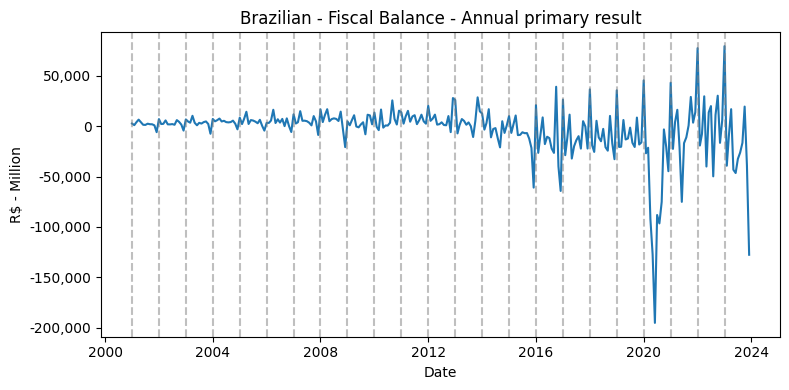

In [38]:
# Let's check the series
# plot the series
fig, ax = plt.subplots()
ax.plot(df[target_variable])
for year in range(df.index.year.min(), df.index.year.max() + 1):
    ax.axvline(pd.Timestamp(year, 1, 1), linestyle='--', color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance - Annual primary result')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) ))


plt.tight_layout()
plt.show()


## Decomposition 

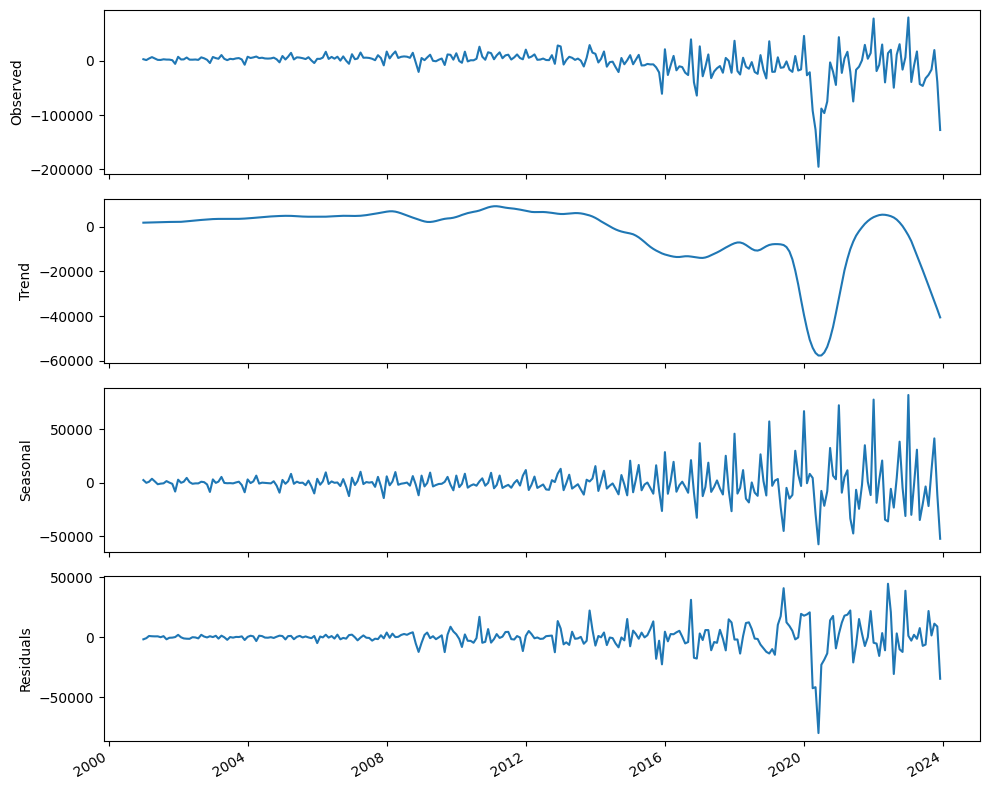

In [39]:
decomposition = STL(df[target_variable], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with SARIMA 

In [40]:
# Check if there is any NA value
print(df[target_variable].isna().sum())

0


In [8]:
# # The series has some outliers, let's remove them
# Q1 = df[target_variable].quantile(0.20)
# Q3 = df[target_variable].quantile(0.80)
# IQR = Q3 - Q1

# df = df[~((df[target_variable] < (Q1 - 1.5 * IQR)) |(df[target_variable] > (Q3 + 1.5 * IQR)))]

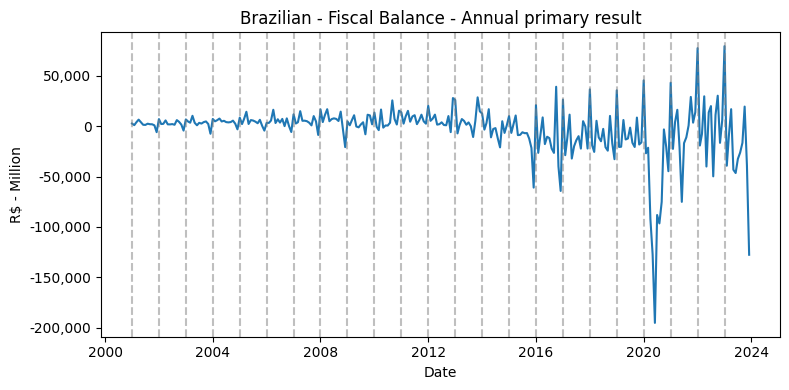

In [41]:
# Let's check the series without the outliers
# plot the series
fig, ax = plt.subplots()
ax.plot(df[target_variable])
for year in range(df.index.year.min(), df.index.year.max() + 1):
    ax.axvline(pd.Timestamp(year, 1, 1), linestyle='--', color='gray', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance - Annual primary result')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) ))


plt.tight_layout()
plt.show()


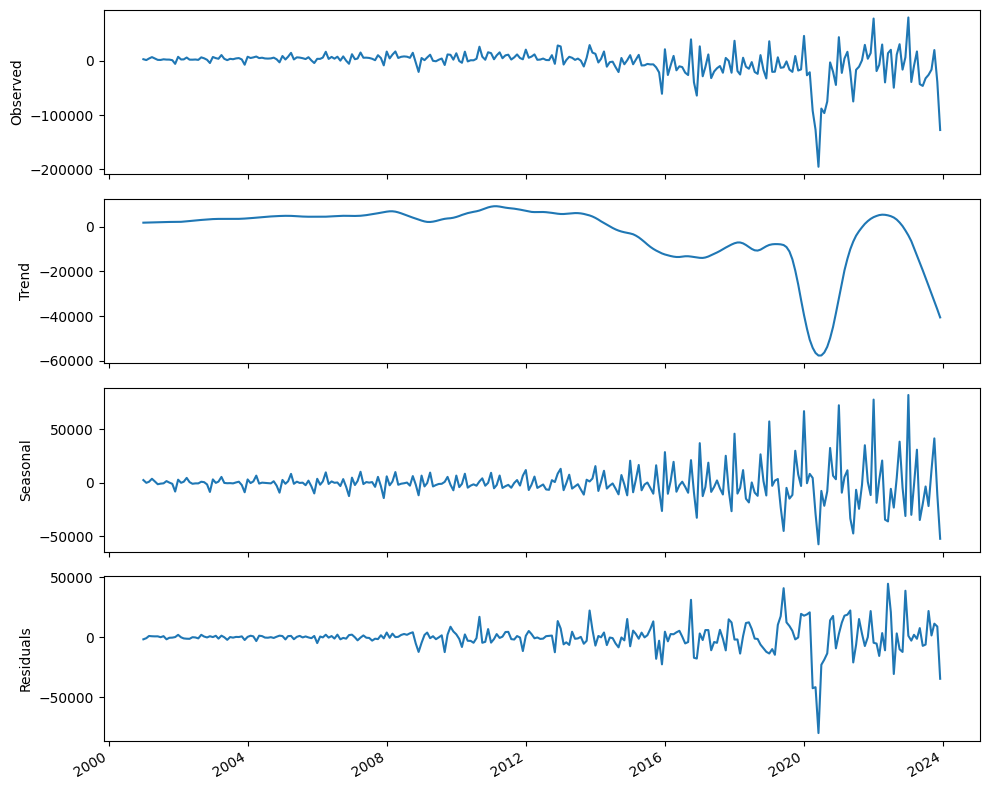

In [42]:
decomposition = STL(df[target_variable], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

In [43]:
# Let's check if the series is stationary

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df.iloc[:,0])
# Print the test statistic and the p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') # if p-value < 0.05, we reject the null hypothesis (H0), the data is stationary

ADF Statistic: -2.563513026920972
p-value: 0.10077527409158393


### Differencing and stationarity

In [44]:
# Since the data is not stationary, we need to difference the series twice due to the tren and the seasonality

df_diff = df['ECO_fiscal_result_month'].diff().diff(periods=12).dropna()

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')



ADF Statistic: -7.200564474152518
p-value: 2.371536924428984e-10


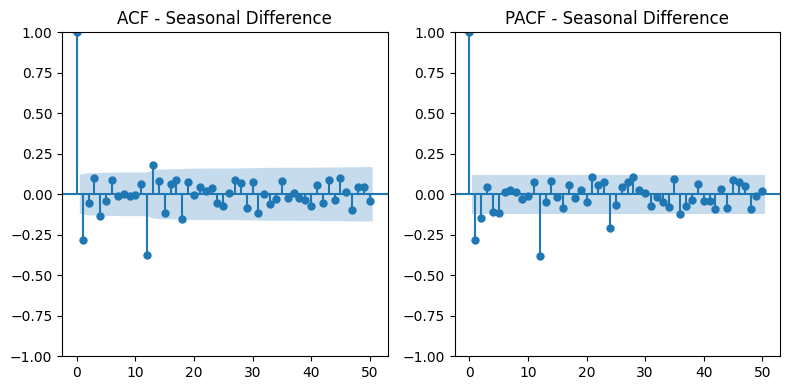

In [45]:
# # Let's plot the ACF and PACF of the differenced series

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Plot ACF on the first subplot
plot_acf(df_diff, lags=50, ax=axs[0])
axs[0].set_title('ACF - Seasonal Difference')

# Plot PACF on the second subplot
plot_pacf(df_diff, lags=50, ax=axs[1])
axs[1].set_title('PACF - Seasonal Difference')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


Since we had to differenciate the data twice to make it stationary, d=1 and D=1 (this last due to the seasonality).
Now let's run a grid search to find the best parameters.

### Define test set 

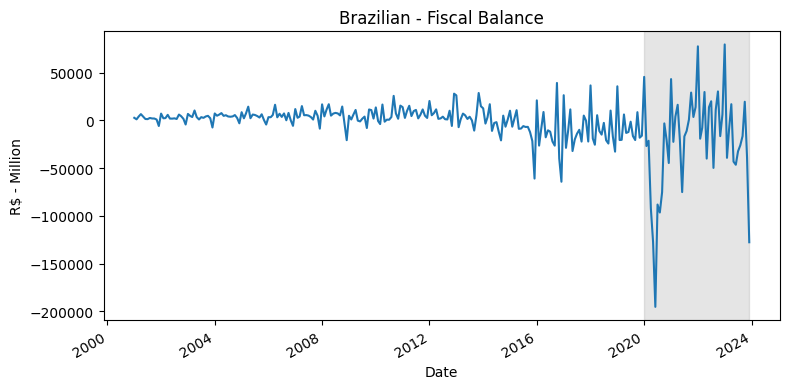

In [46]:
# Define test and validation set sizes
test_size = 48 # months

# Let's print a gray area to represent the test set
fig, ax = plt.subplots()

ax.plot(df.index, df.iloc[:,0], label='Original')
ax.set_xlabel('Date')
ax.set_ylabel('R$ - Million')
ax.set_title('Brazilian - Fiscal Balance')

start_index_test = df.index[len(df) - test_size]
end_index_test = df.index[-1]
# Add a gray area to represent the test set
ax.axvspan(start_index_test, end_index_test, color='#808080', alpha=0.2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [47]:
# Split the data into train and test sets

df_train = df[:-test_size]
df_test = df[-test_size:]

# df_train.index = pd.date_range(start=df_train.index[0], periods=len(df_train), freq='M')
# df_test.index = pd.date_range(start=df_test.index[0], periods=len(df_test), freq='M')

# df_train.index = df_train.index.to_period('M').to_timestamp() - pd.offsets.MonthBegin(0)
# df_test.index = df_test.index.to_period('M').to_timestamp() - pd.offsets.MonthBegin(0)

### Model selection with AIC 

In [48]:
# Define a SARIMA grid search function
def SARIMA_gridsearch(dataframe, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s):
    # Create a list with all possible combinations of p, d and q
    all_p = range(min_p, max_p+1, 1)
    all_q = range(min_q, max_q+1, 1)
    all_P = range(min_P, max_P+1, 1)
    all_Q = range(min_Q, max_Q+1, 1)
    # All possible combinations of seasonal orders
    all_orders = list(product(all_p, all_q, all_P, all_Q))
    print(f'Fitting {len(all_orders)} unique models')
    
    # Create an empty list to store the results
    results = []
    
    for order in tqdm(all_orders):
        try: # Try to fit the model
            model = SARIMAX(
                dataframe, 
                order=(order[0], d, order[1]), # Non-seasonal order p,d,q
                seasonal_order=(order[2], D, order[3], s)).fit(disp=False) # Seasonal order P,D,Q,s
        except:
            continue
        # Append the results to the list    
        results.append([order, model.aic])
        # if model.mle_retvals['converged'] is False:
        #     print("Maximum Likelihood optimization did not converge.")
        #     print("Convergence status:", model.mle_retvals['converged'])
        #     print("Number of iterations:", model.mle_retvals['iterations'])
        #     try:
        #         print("Function value at the solution:", model.mle_retvals['fun'])
        #     except KeyError:
        #         print("Function value at the solution not available.")
    # Convert the results list to a DataFrame 
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better - Akaike's Information Criterion
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [49]:
# Define the range of the parameters theoerically possible
min_p = 0
max_p = 4
min_q = 0
max_q = 4

min_P = 0
max_P = 4
min_Q = 0
max_Q = 4

d = 1 # Non-seasonal difference. We already differenced the series once
D = 1 # Seasonal difference. We already differenced the series once with n_lag=12
s = 12 # Seasonal cycle length
# Fit the SARIMA model using the gridsearch function
result_df = SARIMA_gridsearch(df_train, min_p, max_p, min_q, max_q, min_P, max_P, min_Q, max_Q, d, D, s)
# Display the top 5 models, sorted by AIC
result_df.head()

Fitting 625 unique models


100%|█████████▉| 622/625 [52:40<01:04, 21.39s/it]  

In [21]:
# Check the best parameters
best_params = result_df.iloc[0]['(p,q,P,Q)']
p, q, P, Q = best_params
best_params

(1, 2, 3, 4)

In [22]:
# Fit the best SARIMA model using the best parameters
# Create the SARIMA model
SARIMA_model = SARIMAX(df_train, order=(p, d, q), seasonal_order=(P, D, Q, s))
# Fit the SARIMA model
SARIMA_model_fit = SARIMA_model.fit(disp=False)
# Print the model summary
print(SARIMA_model_fit.summary())

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                           SARIMAX Results                                           
Dep. Variable:                       ECO_fiscal_result_month   No. Observations:                  228
Model:             SARIMAX(1, 1, 2)x(3, 1, [1, 2, 3, 4], 12)   Log Likelihood                   0.000
Date:                                       Tue, 19 Mar 2024   AIC                             22.000
Time:                                               11:20:56   BIC                             59.077
Sample:                                           01-31-2001   HQIC                            36.981
                                                - 12-31-2019                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0000   1.

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3015: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


### Residuals analysis 

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

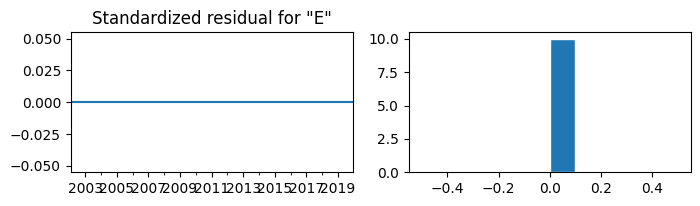

In [23]:
# Let's plot the residuals
SARIMA_model_fit.plot_diagnostics();

In [ ]:
# Define a ljung box test method to check for autocorrelation in the residuals
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal:
        lb_df = acorr_ljungbox(residuals, period=period)
    else:
        max_lag = min([10, len(residuals)/5])
        
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black') # Threshold line at 0.05 - p-value significance level
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. We fail to reject the null hypothesis. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

At least one p-value is smaller than 0.05


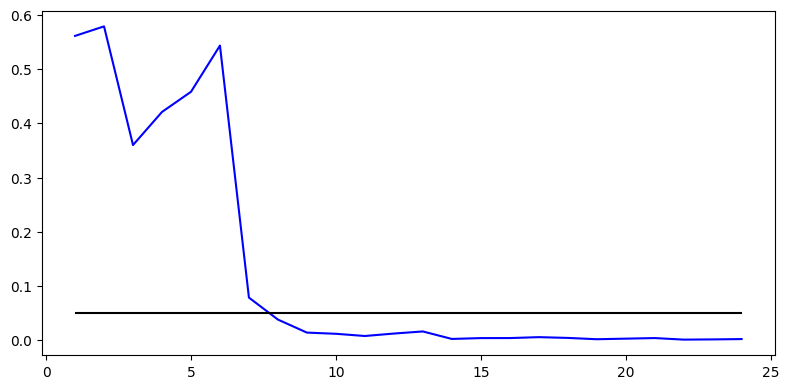

In [ ]:
# Use ljung box test to check for autocorrelation in the residuals.
residuals = SARIMA_model_fit.resid
# 
ljung_box_test(residuals, True, 12)

### Forecasting 

In [31]:
# Define a method to compute the rolling predictions

def rolling_predictions(df, train_len, horizon, window, period, method):
    
    # Define the total length of the time series
    TOTAL_LEN = train_len + horizon
    
    # Define the number of seasonal steps
    seasonal_steps = int((window/period))
    
    # Check the type of desired prediction
    if method == 'mean':
        pred_mean = []
        # Compute the mean of the training set
        for i in range(train_len, TOTAL_LEN, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean[:horizon]

    elif method == 'last':
        pred_last_value = []
        # Get the last value of the training set
        for i in range(train_len, TOTAL_LEN, window):
            last_value = np.diff[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value[:horizon]
    
    elif method == 'last_season':
        pred_last_season = []
        # Get the last season of the training set
        for i in range(train_len, TOTAL_LEN, window):
            last_season = df[:i][-period:].values
            pred_last_season.extend(last_season for _ in range(seasonal_steps))

        pred_last_season = np.array(pred_last_season).reshape(1, -1)
        
        return pred_last_season[0][:horizon]
    
    if method == 'SARIMA':
        pred_SARIMA = []
        # Fit the model and compute the predictions with SARIMA
        for i in range(train_len, TOTAL_LEN, window):
            # Define the model's parameters
            model = SARIMAX(df[:i], order=(p, d, q), seasonal_order=(P, D, Q, s))
            res = model.fit(disp=False) # Fit the model
            predictions = res.get_prediction(0, i + window - 1) # Compute the predictions
            oos_pred = predictions.predicted_mean[-window:] # Get the out-of-sample predictions
            pred_SARIMA.extend(oos_pred) # Append the predictions to the list
            
        return pred_SARIMA[:horizon]

In [32]:
# Predictions

# Create a copy of the test set to store the original test set
pred_df = df_test.copy()
# Rename the first column to the name of the target variable
#pred_df = pd.DataFrame(pred_df, columns=[target_variable])

# Define the length of the train and test sets
TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

# Define the rolling window sizes
windows = [1, 12, 24, 36]

# Create a column for each window size
for window in windows:
    # Call the rolling_predictions function for each window size
    #pred_last_season = rolling_predictions(df[target_variable], TRAIN_LEN, HORIZON, window, 12, 'last_season')
    pred_SARIMA = rolling_predictions(df_train[target_variable], TRAIN_LEN, HORIZON, window, 12, 'SARIMA')
    # Assign the predictions to the corresponding column
    #pred_df[f'pred_last_season_{window}'] = pred_last_season
    pred_df[f'pred_SARIMA_{window}'] = pred_SARIMA
    


g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai

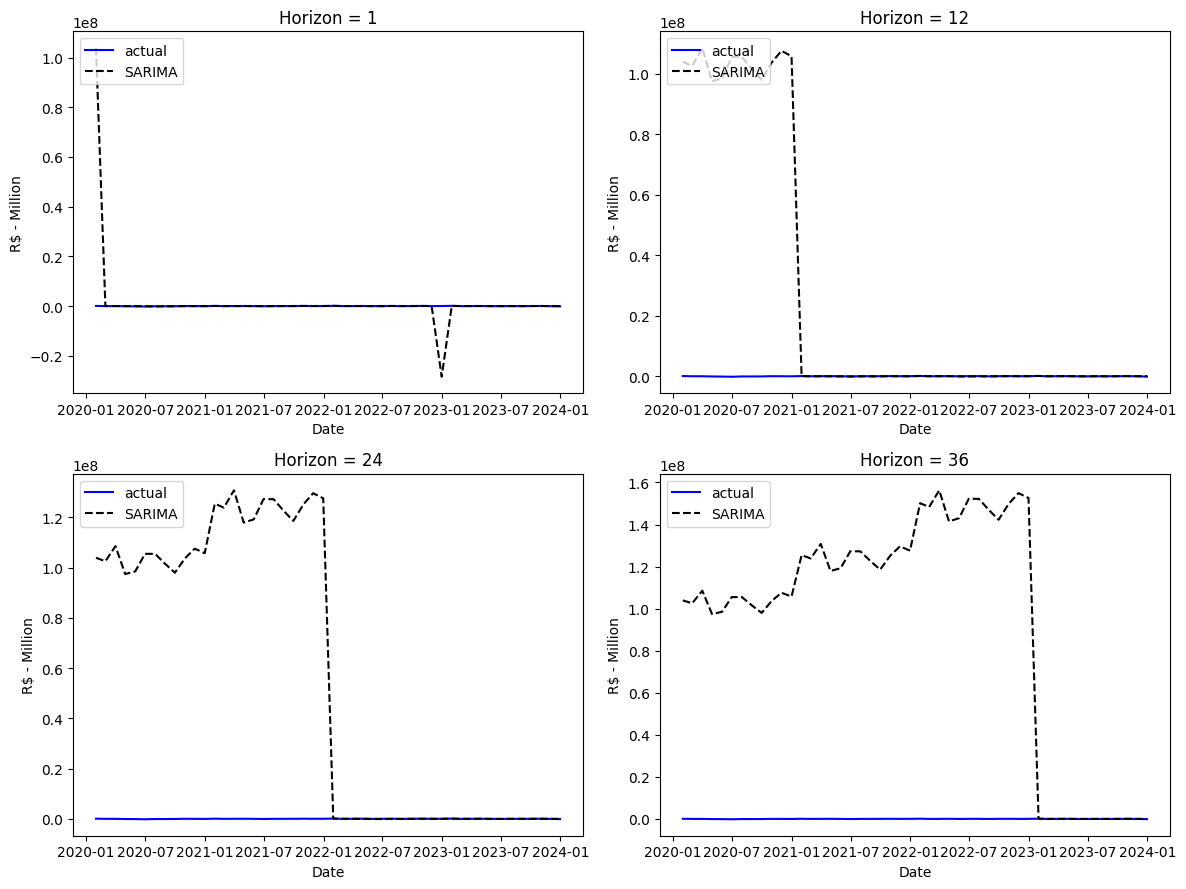

In [28]:
# # Plot the actual and predicted values

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,9))

for i, ax in enumerate(axes.flatten()):
    
    #ax.plot(df[target_variable])
    ax.plot(pred_df[target_variable], 'b-', label='actual')
    #ax.plot(pred_df[f'pred_last_season_{windows[i]}'], 'r-.', label='last_season')
    ax.plot(pred_df[f'pred_SARIMA_{windows[i]}'], 'k--', label='SARIMA')
    
    ax.legend(loc=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('R$ - Million')
    ax.set_title(f'Horizon = {windows[i]}')
    
plt.tight_layout()

#### Evaluation 

In [29]:
# Calculate the Mean Absolute Percentage Error (MAPE)
# def mape(y_true, y_pred):
#     return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

errors = {}

for window in windows:
    #pred_last_season = pred_df[f'pred_last_season_{window}']
    pred_SARIMA = pred_df[f'pred_SARIMA_{window}']
    
    #mape_naive_seasonal = mape(pred_df[target_variable], pred_last_season)
    mape_SARIMA_grid = mean_absolute_percentage_error(pred_df[target_variable], pred_SARIMA)
    #rmse_naive_seasonal = sqrt(mean_squared_error(pred_df[target_variable], pred_last_season))
    rmse_SARIMA_grid = root_mean_squared_error(pred_df[target_variable], pred_SARIMA)
    #mae_naive_seasonal = mean_absolute_error(pred_df[target_variable], pred_last_season)
    mae_SARIMA_grid = mean_absolute_error(pred_df[target_variable], pred_SARIMA)
    
    errors[window] = {
        #'mape_naive_seasonal': mape_naive_seasonal,
        'mape_SARIMA_grid': mape_SARIMA_grid,
        #'rmse_naive_seasonal': rmse_naive_seasonal,
        'rmse_SARIMA_grid': rmse_SARIMA_grid,
        #'mae_naive_seasonal': mae_naive_seasonal,
        'mae_SARIMA_grid': mae_SARIMA_grid
    }

# Accessing error metrics for a specific window
for window in windows:
    print(f"Error metrics for window {window}:",  errors[12])




Error metrics for window 1: {'mape_SARIMA_grid': 1191.8908021678046, 'rmse_SARIMA_grid': 51658415.6961041, 'mae_SARIMA_grid': 25838877.289237175}
Error metrics for window 12: {'mape_SARIMA_grid': 1191.8908021678046, 'rmse_SARIMA_grid': 51658415.6961041, 'mae_SARIMA_grid': 25838877.289237175}
Error metrics for window 24: {'mape_SARIMA_grid': 1191.8908021678046, 'rmse_SARIMA_grid': 51658415.6961041, 'mae_SARIMA_grid': 25838877.289237175}
Error metrics for window 36: {'mape_SARIMA_grid': 1191.8908021678046, 'rmse_SARIMA_grid': 51658415.6961041, 'mae_SARIMA_grid': 25838877.289237175}


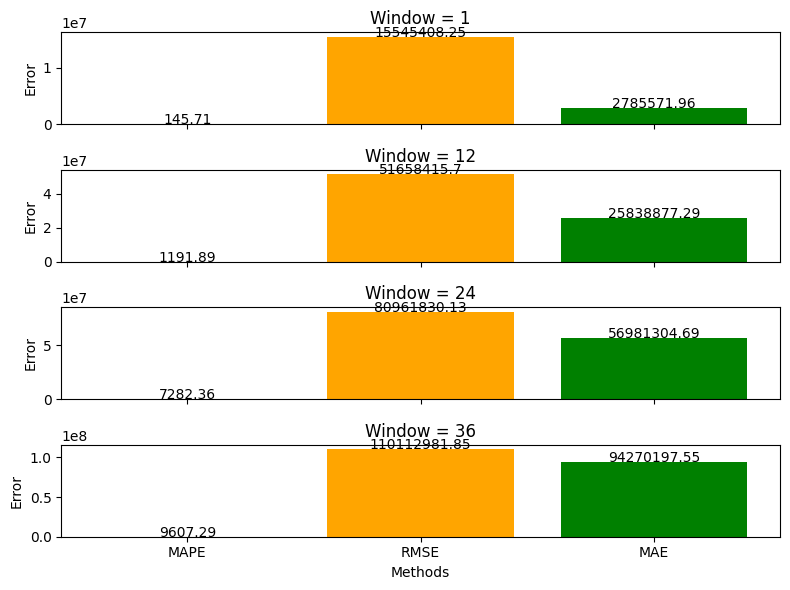

In [30]:

# Define error metrics and methods
methods = ['MAPE', 'RMSE', 'MAE']

# Create subplots for each window
fig, axs = plt.subplots(nrows=len(windows), ncols=1, figsize=(8, 6), sharex=True)

# Iterate over windows
for i, window in enumerate(windows):
    # Extract error values for the given window
    errors_window = errors[window]
    
    # Extract error values for each method
    error_values = [errors_window[f'{method.lower()}_SARIMA_grid'] for method in methods]
    
    # Plot bars for each method in the subplot
    axs[i].bar(methods, error_values, color=['blue', 'orange', 'green'])
    axs[i].set_title(f'Window = {window}')
    axs[i].set_ylabel('Error')
    
    # Display error values above the bars
    for index, value in enumerate(error_values):
        axs[i].text(x=index, y=value + 0.5, s=str(round(value, 2)), ha='center')

# Set common x-label
plt.xlabel('Methods')

plt.tight_layout()
plt.show()





### A differente aproach using auto_arima

In [ ]:
# Find the best parameters using auto_arima function
auto_model = auto_arima(df_train, seasonal=True, m=12, trace=False,
                        error_action='ignore', suppress_warnings=True)

# Adjust the model with the best parameters and train it
model = SARIMAX(df_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model_fit = model.fit(disp=False)

# Predict for the test period
predictions = model_fit.forecast(steps=len(df_test))


In [ ]:
# Show best parameters
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 1, 1)
(1, 0, 1, 12)


In [ ]:
# Evaluate the model
#from math import sqrt
mape_SARIMA_auto = mean_absolute_percentage_error(df_test, predictions)
rmse_SARIMA_auto = root_mean_squared_error(df_test, predictions)
mae_SARIMA_auto = mean_absolute_error(df_test, predictions)
print(f'MAPE SARIMA AUTO: {mape_SARIMA_auto}')
print(f'RMSE SARIMA AUTO: {rmse_SARIMA_auto}')
print(f'MAE SARIMA AUTO: {mae_SARIMA_auto}')

MAPE SARIMA AUTO: 1.2957224551787838
RMSE SARIMA AUTO: 19844.08301480383
MAE SARIMA AUTO: 16418.92313113919


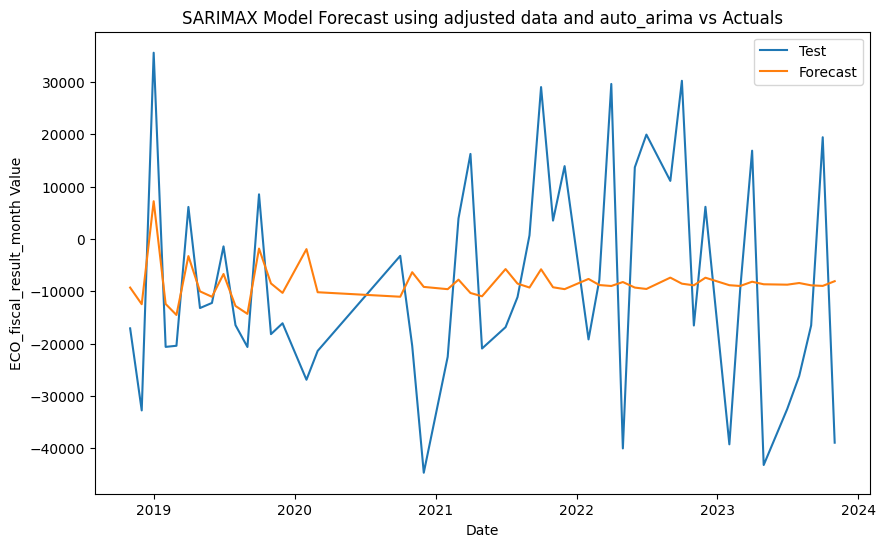

In [ ]:
# Plot SARIMAX Model Forecast(auto_arima) vs Actuals

uf.plot_forecast_vs_test(
    target_variable, 
    df_train[target_variable], 
    df_test[target_variable], 
    predictions, 
    'SARIMAX Model Forecast using adjusted data and auto_arima vs Actuals')



In [ ]:
# Now let's repeat the process using the original data maintaining the outliers

# source: https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv

# load the data
file_path = '../data/BR_param_EDA.csv'
# parse the date column and set it as the index of the dataframe
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# subset df to get only the columns 'date', 'eco_fiscal_result_month'
target_variable = 'ECO_fiscal_result_month'
df = df[[target_variable]]
# Define test and validation set sizes
test_size = 48 # number of months
# Split the data into train and test sets
df_train = df[:-test_size]
df_test = df[-test_size:]



In [ ]:
# Find the best parameters using auto_arima function
auto_model2 = auto_arima(df_train, seasonal=True, m=12, trace=False,
                        error_action='ignore', suppress_warnings=True)

# Adjust the model with the best parameters and train it
model2 = SARIMAX(df_train, order=auto_model2.order, seasonal_order=auto_model2.seasonal_order)
model_fit2 = model2.fit(disp=False)

# Predict for the test period
predictions2 = model_fit2.forecast(steps=len(df_test))

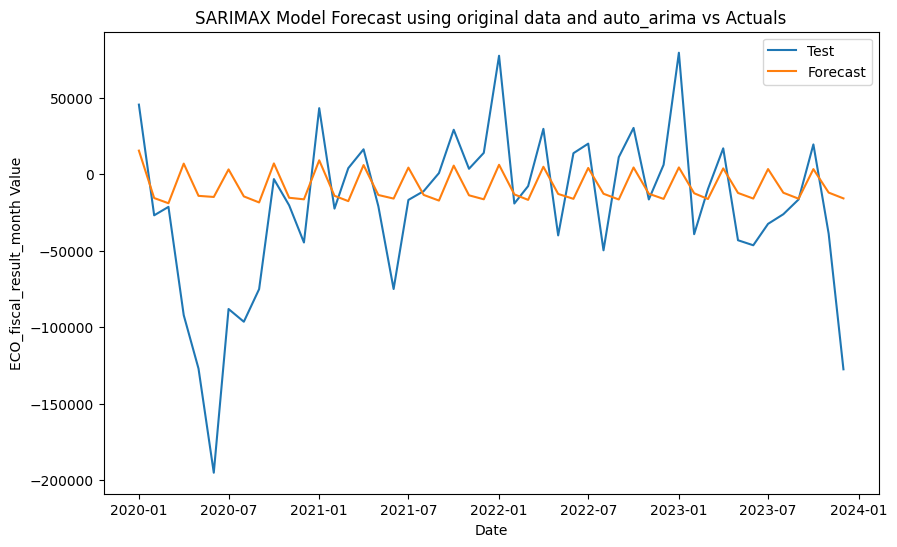

In [ ]:
# Plot SARIMAX Model Forecast(auto_arima) vs Actuals

uf.plot_forecast_vs_test(
    target_variable, 
    df_train[target_variable],
    df_test[target_variable], 
    predictions2, 
    'SARIMAX Model Forecast using original data and auto_arima vs Actuals')



In [ ]:
# Show best parameters
print(auto_model2.order)
print(auto_model2.seasonal_order)

# Evaluate the model
mape_SARIMA_Auto_outliers = mean_absolute_percentage_error(df_test, predictions2)
rmse_SARIMA_Auto_outliers = root_mean_squared_error(df_test, predictions2)
mae_SARIMA_Auto_outliers = mean_absolute_error(df_test, predictions2)
print(f'MAPE SARIMA AUTO: {mape_SARIMA_Auto_outliers}')
print(f'RMSE SARIMA AUTO: {rmse_SARIMA_Auto_outliers}')
print(f'MAE SARIMA AUTO: {mae_SARIMA_Auto_outliers}')


(4, 1, 4)
(1, 0, 0, 12)
MAPE SARIMA AUTO: 1.6094252638277557
RMSE SARIMA AUTO: 49494.93299487701
MAE SARIMA AUTO: 34400.532700347554


### Forecast with SARIMA best model

In [ ]:
# Let's reset our data

# Now let's repeat the process using the orginal data maintaining the outliers

# source: https://raw.githubusercontent.com/plotly/datasets/master/monthly-milk-production-pounds.csv

# load the data
file_path = '../data/BR_param_EDA.csv'
# parse the date column and set it as the index of the dataframe
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
# subset df to get only the columns 'date', 'eco_fiscal_result_month'
target_variable = 'ECO_fiscal_result_month'
df = df[[target_variable]]



In [ ]:
# ATTENTION: This chunck of code should only be used if the best results were found removing the outliers

# The series has some outliers, let's remove them
Q1 = df[target_variable].quantile(0.20)
Q3 = df[target_variable].quantile(0.80)
IQR = Q3 - Q1

df = df[~((df[target_variable] < (Q1 - 1.5 * IQR)) |(df[target_variable] > (Q3 + 1.5 * IQR)))]

In [ ]:
# Define test and validation set sizes
test_size = 48 # number of months
# Split the data into train and test sets
df_train = df[:-test_size]
df_test = df[-test_size:]

In [ ]:
# Final predicition

# Define the number of future steps
future_steps = 24

# Get the last available date in your dataset
last_date = pd.to_datetime(df.index)[-1]

# Generate future dates for the index
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

# Forecast using fitted model to forecast future values
forecast = model_fit.forecast(steps=future_steps)

# Create a DataFrame to store the forecasted values with corresponding dates
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])


In [ ]:
# Preparing for cross-validation
# Define a function for walk-forward validation

# Using the first column after 'date' for SARIMA modeling
time_series = df.iloc[:, 0]

# Define future horizon
future_horizon = 24
horizon = future_horizon + test_size

def walk_forward_validation(data, n_test):
    history = [x for x in data]
    predictions = list()
    for i in range(n_test):
        model = SARIMAX(history[:-n_test+i], order=auto_model.order, seasonal_order=auto_model.seasonal_order)
        model_fit = model.fit(disp=False)
        pred = model_fit.forecast()
        predictions.append(pred[0])
        history.append(data[-n_test+i])
    error_mape_best_SARIMA = mean_absolute_percentage_error(data[-n_test:], predictions)
    error_rmse_best_SARIMA = root_mean_squared_error(data[-n_test:], predictions)
    error_mae_best_SARIMA = mean_absolute_error(data[-n_test:], predictions)
    return error_mape_best_SARIMA, error_rmse_best_SARIMA, error_mae_best_SARIMA, predictions

# Perform walk-forward validation
error_mape_best_SARIMA, error_rmse_best_SARIMA, error_mae_best_SARIMA, predictions = walk_forward_validation(time_series.tolist(), horizon)
print(f'MAPE_best_SARIMA: {error_mape_best_SARIMA}')
print(f'RMSE_best_SARIMA: {error_rmse_best_SARIMA}')
print(f'MAE_best_SARIMA: {error_mae_best_SARIMA}')

# Copy index from the test set + future dates
last_month = df_test.index[-1]

# Creating a new index with future_horizon additional months
future_index = pd.date_range(start=last_month, periods=future_horizon+1, freq='MS')[1:]

# Combining the future index with the existing index of df_test
combined_index = df_test.index.union(future_index)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, index = combined_index, columns=['Predicted'])



MAPE_best_SARIMA: 1.7908292554836334
RMSE_best_SARIMA: 23734.772433181315
MAE_best_SARIMA: 19891.73287183589


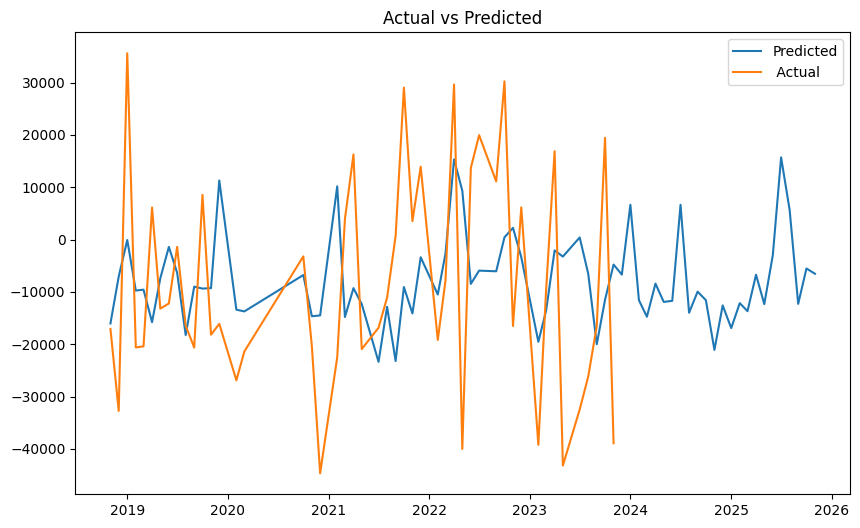

In [ ]:
# Plotting training and test error
plt.figure(figsize=(10, 6))
plt.plot(predictions_df, label='Predicted')
plt.plot(df_test.index[-test_size:], time_series.tolist()[-test_size:], label=' Actual')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
# Get the prediction for 2024-12 and the last prediction in the dataset showing the index and the value
print("The forecasted result at the end of 2024 is: {}".format(predictions_df.loc['2024-12']))
# Print a new line
print("\n")
print("The last forecasted result is: {}".format(predictions_df.tail(1)))





The forecasted result at the end of 2024 is:                Predicted
2024-12-01 -12580.447507


The last forecasted result is:               Predicted
2025-11-01 -6531.285807


In [ ]:
# um outro de jeito de fazer a previsão:
#Reference:https://medium.com/@reddyyashu20/auto-regression-ar-model-in-python-time-series-forecasting-part-5-pratical-session-c9997481e460
pred_future=model.predict(start=len(X)+1,end=len(x)+7,dynamic=False)
print("the future prediction for the next week")
print(pred_future)
print('Number of predictions Made:\t',len(pred_future))



NameError: name 'X' is not defined